<a href="https://colab.research.google.com/github/parlange/taller-gpt/blob/main/mnist_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de dígitos con Vision Transformer

## Dataset MNIST
### Versión reducida mnist_784
### Dataset: 60,000 para entrenamiento y 10,000 para validación
### Subconjunto: 8,000 para entrenamiento y 2,000 para validación

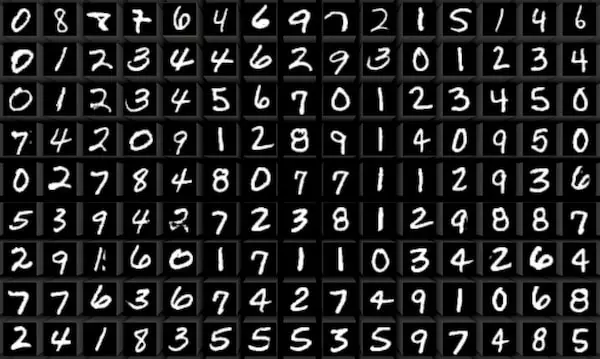

## Arquitectura Vision Transformer (ViT)

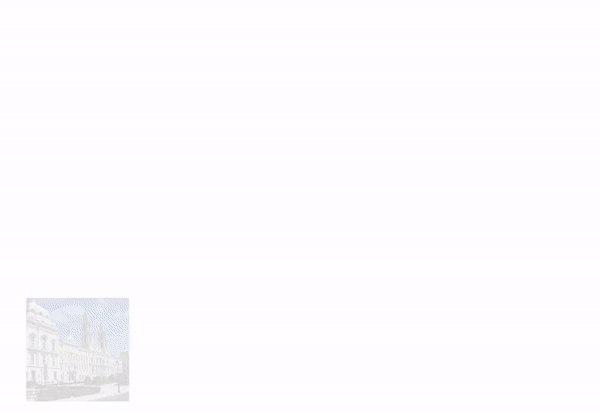

In [ ]:
!pip install torch torchvision scikit-learn matplotlib seaborn tqdm transformers

### Importar torch, torchvision, sklearn, seaborn, transformers, tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import ViTForImageClassification
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

### Descargar el dataset mnist_784 y particionar en subconjuntos de entrenamiento y validación

In [ ]:
# Descarga y prepara el dataset reducido de MNIST
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data.to_numpy(), mnist.target.astype(int)
X = X.reshape(-1, 28, 28).astype(np.float32) / 255.0  # Normaliza las imágenes

# Divide el dataset
X_train, X_test = X[:8000], X[8000:10000]
y_train, y_test = y[:8000], y[8000:10000]

# Convertir a tensores de PyTorch
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # Arreglos numpy para índices correctos
        label = self.labels[idx] if isinstance(self.labels, np.ndarray) else self.labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNISTDataset(X_train, y_train, transform=transform)
test_dataset = MNISTDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Cargar el modelo Vision Transformer (ViT) preentrenado con ImageNet de 21,000 clases y entrenar un modelo que clasifique dígitos MNIST

In [ ]:
# Cargar el modelo ViT preentrenado
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Configurar el optimizador y la función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Entrenamiento del modelo
num_epochs = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                            


Epoch [1/1], Loss: 0.5650


### Evaluar el desempeño del modelo sobre el dataset

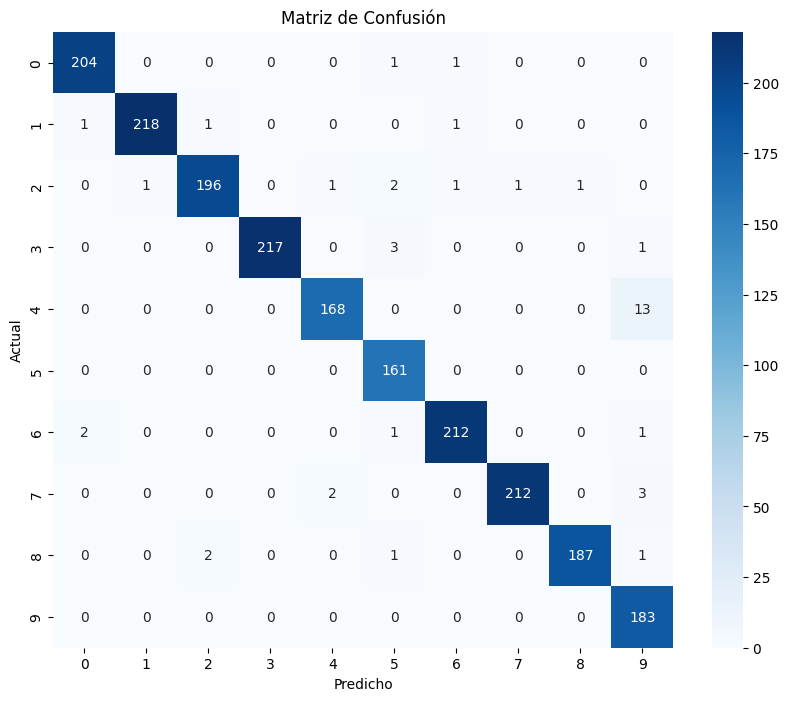

In [ ]:
# Evaluación del modelo
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Evaluando', leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

### Visualizar desempeño con la curva ROC

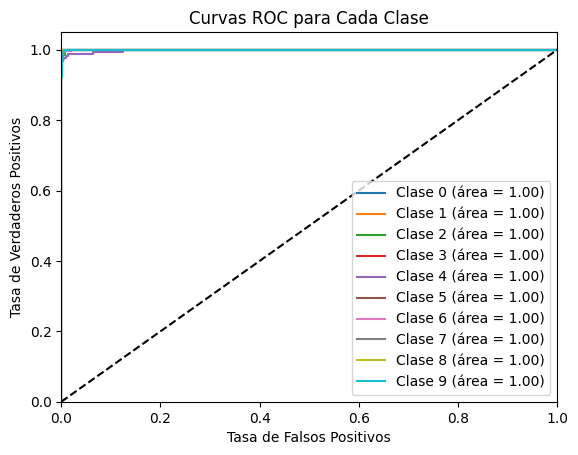

In [ ]:
# Curvas ROC
all_labels_bin = label_binarize(all_labels, classes=range(10))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (área = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para Cada Clase')
plt.legend(loc='lower right')
plt.show()

### Visualizar las imágenes de los dígitos 0-9 (predicción vs. valor real)

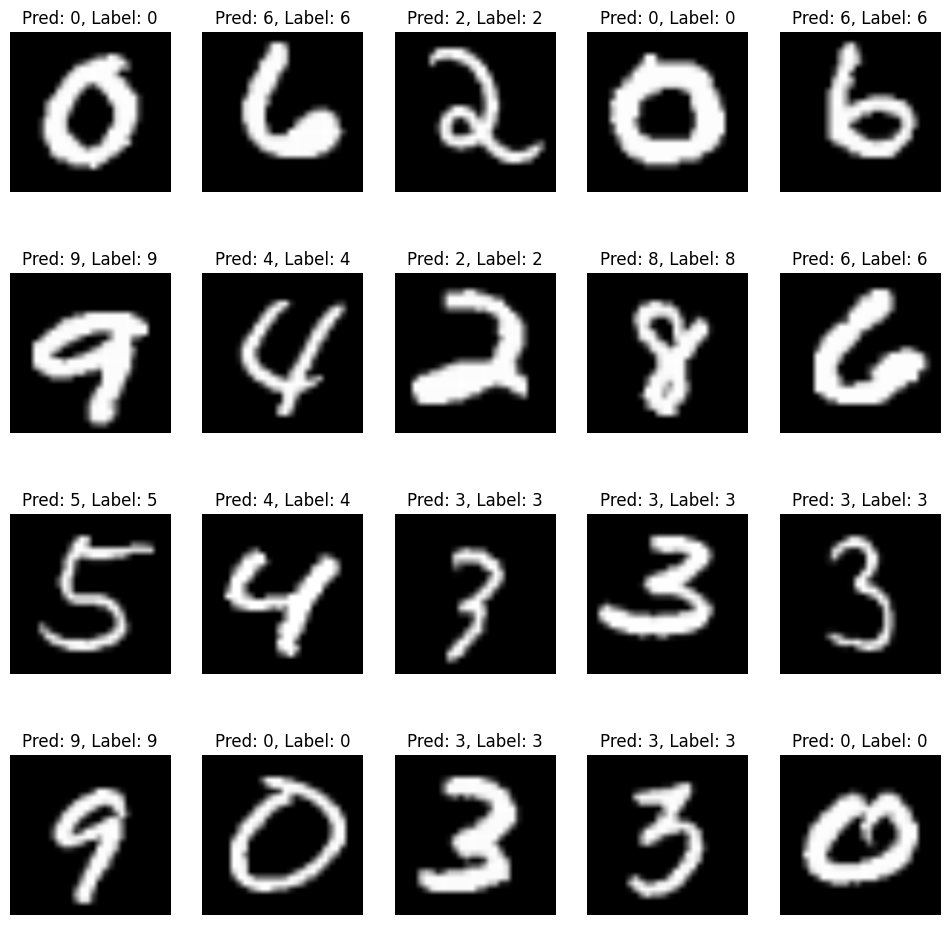

In [ ]:
# Crear un mosaico con predicciones y etiquetas
def show_images(images, labels, preds, num_images=20):
    images = images * 0.5 + 0.5  # Des-normalizar las imágenes para llevar los valores al rango [0, 1]
    images = images.clamp(0, 1)  # Asegurar que los valores estén en el rango [0, 1]
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
        plt.title(f'Pred: {preds[i]}, Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Obtener algunas imágenes de prueba y sus predicciones
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
outputs = model(images).logits
_, preds = torch.max(outputs, 1)

# Mostrar el mosaico
show_images(images, labels, preds)
